# Semantic Segmentation Exercises

Based on exercise from DLCV 2019 by ASM Shihavuddin and Ricardo Cruz

The data used for this exercise stems from the ISBI cell tracking challenge http://celltrackingchallenge.net/. The data loader below assumes that you are working on the HPC machines with the data located at  

/dtu/datasets1/02514/phc_data

If this is not the case, you will have to adapt the data loader accordingly.

These are microscopy images taken over time of different cells that move around in the image plane; the images you will be working with have been processed to contain only a single cell each.

Have a look at the phc_data folder. It is structured like this:

    images/
        img_00000.jpg
        img_00001.jpg
            ...
    labels
        label_00000.png
        label_00001.png 
            ...
            
We provide you with a class similar to the Hotdog_NotHotdog data loader that will allow you to load the dataset from  /dtu/datasets1/02514/

First, we load some needed libraries

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output

print("Running on ", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

/work3/s183920/02514-DLCI/DLCI-venv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/work3/s183920/02514-DLCI/DLCI-venv/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator9allocatorE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Running on  cuda


Next, the data loader

In [2]:
data_path = '/dtu/datasets1/02514/phc_data'
#data_path = './phc_data'
class PhC(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path=data_path):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        self.image_paths = sorted(glob.glob(data_path + '/images/*.jpg'))
        self.label_paths = sorted(glob.glob(data_path + '/labels/*.png'))
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        
        image = Image.open(image_path)
        label = Image.open(label_path)
        Y = self.transform(label)
        X = self.transform(image)
        return X, Y

In principle, the images could have different sizes. Let's resize them all to $128\times128$ pixels, using the torchvision Resize. 

In [3]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 6
trainset = PhC(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
testset = PhC(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=3)

In [4]:
print('Loaded %d training images' % len(trainset))
print('Loaded %d test images' % len(testset))

Loaded 151 training images
Loaded 500 test images


Let's look at some images from the dataset!

In [4]:
plt.rcParams['figure.figsize'] = [18, 6]

images, labels = next(iter(train_loader))

for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i], 0, 2), 0, 1))

    plt.subplot(2, 6, i+7)
    plt.imshow(labels[i].squeeze())
plt.show()

## Device

Check if GPU is available.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


First, we implement a simple encoder decoder network for image registration

In [5]:
class EncDec(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(64, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

## Loss

Now, as important as building the architecture is defining **the optimizer** and **the loss function.**

The **loss function** is what we are trying to minimize. Many can be used. A popular one for binary segmentation is *binary cross-entropy* which is given by

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

where $y$ is the desired output and $\hat y$ is the output of the model. $\sigma$ is the [*logistic* function](https://en.wikipedia.org/wiki/Sigmoid_function) (also called *sigmoid*), which converts a real number $\mathbb R$ into a probability $[0,1]$.

However, this loss suffers from numerical stability problems. Most importantly, $\lim_{x\rightarrow0}\log(x)=\infty$ which leads to optimization unstability. This loss [can be simplified](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) into the following loss, which is equivalent and is not as prone to numerical unstability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

> NOTE: Sum is replaced by mean to reduce the influence of outliers, i.e. loss is averaged over all pixels instead of over all images.

In [6]:
def bce_loss(y_real, y_pred, clip = False):
    m = nn.Sigmoid()
    loss = nn.BCELoss()
    return loss(m(y_pred), y_real)
    # return F.binary_cross_entropy_with_logits(y_pred, y_real)
    # return torch.mean(y_pred - y_real*y_pred + torch.log(1 + torch.exp(-y_pred)))

# avg_loss = 0
# for X_batch, Y_batch in train_loader:
#     X_batch = X_batch.to(device)
#     Y_batch = Y_batch.to(device)

#     Y_pred = model(X_batch)
#     loss = bce_loss(Y_batch, Y_pred)
    
#     avg_loss += loss / len(train_loader)
# avg_loss

Can you still see situations in which this loss might be unstable? How would you change it?

> Unstable if $\hat y$ is very large and positive. We could add a term to the loss that penalizes large values of $\hat y$.

## Training

We will define the training cycle in a function so we can re-use it.

In [7]:
def train(model, opt, loss_fn, epochs, train_loader, test_loader):
    X_test, Y_test = next(iter(test_loader))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)
            # loss = loss_fn(Y_batch, torch.argmax(Y_pred, dim = 1))  # forward-pass
            loss = loss_fn(Y_batch, Y_pred)  # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(train_loader)
        toc = time()
        print(' - loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = F.sigmoid(model(X_test.to(device))).detach().cpu()
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Predict

After the model is trained, you can use this function to predict segmentations for new data:

In [8]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [F.sigmoid(model(X_batch.to(device))) for X_batch, _ in data]
    return np.array(Y_pred)

## Lights. Camera. Action.

Let us instanciate the model and train it.

In [11]:
model = EncDec().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
         MaxPool2d-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,928
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,928
         MaxPool2d-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,928
         Upsample-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          36,928
         Upsample-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,928
         Upsample-14           [-1, 64,

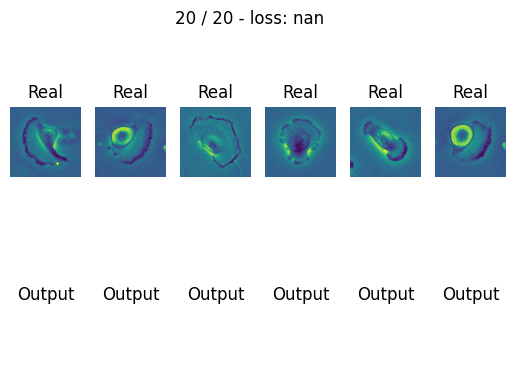

In [38]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

-----------------------------------------------------------------------------------------

# Other losses

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Implement the following losses:
<ol>
    <li>Probabilistic Dice coefficient</li>
    <li>Focal loss</li>
</ol>
</div>

**1. Dice coefficient:** Given two masks $X$ and $Y$, a common metric to measure the distance between these two masks is given by:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

This function is not differentiable and the loss function <b>must</b> always be differentiable for gradient descent to work. But we can approximate it using:

<!-- $$\mathcal L_D(X,Y) = 1-\frac{1}{256\times256}\sum_i\frac{2X_iY_i}{X_i+Y_i}.$$ -->
$$ \mathcal L_D(X,Y) = 1-\frac{mean(2XY + 1)}{mean(X+Y)+1}.$$

Implement this loss:

In [65]:
def dice_loss(y_real, y_pred):
    y_pred = F.sigmoid(y_pred)
    nom = torch.mean(2*y_real*y_pred + 1, dim = (-2, -1))
    denom = torch.mean(y_real + y_pred, dim = (-2, -1)) + 1
    return torch.mean(1-nom / denom)

Run it:

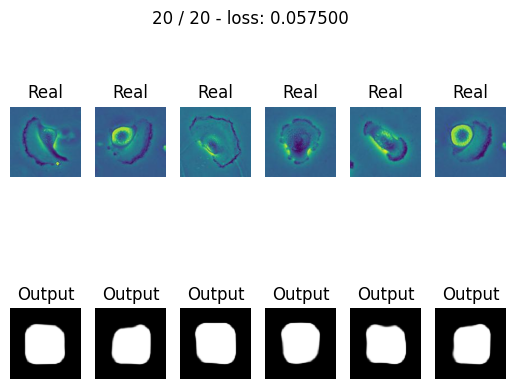

In [66]:
model = EncDec().to(device)
train(model, optim.Adam(model.parameters(), 0.0001), dice_loss, 20, train_loader, test_loader)

**2. Focal loss:** First, remember how binary crossentropy looks like:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

The problem with this loss is that it tends to benefit the **majority** class (usually the background) relative to the **minority** class (usually the foreground). Therefore, usually people apply weights to each class:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Traditionally, the weight $\alpha_i$ is defined as the inverse frequency of the class of that pixel $i$, so that observations of the minority class weight more relative to the majority class.

Another recent addition has been the **focal loss** which weights each pixel by the confidence we have in the prediction of that pixel.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

A good value for $\gamma$ is generally 2.

* Lin, Tsung-Yi, et al. "[Focal loss for dense object detection.](https://arxiv.org/pdf/1708.02002.pdf)" Proceedings of the IEEE international conference on computer vision. 2017.

------------------------------------------------------------------------------------------------------

Implement focal loss:

In [7]:
def focal_loss(y_real, y_pred, gamma = 2):
    X = y_real
    Y = F.sigmoid(y_pred)
    
    focal = torch.sum((1-Y)**gamma * X * torch.log(Y) + (1-X) * torch.log(1-Y), dim = (-2, -1))
    
    return -torch.mean(focal)

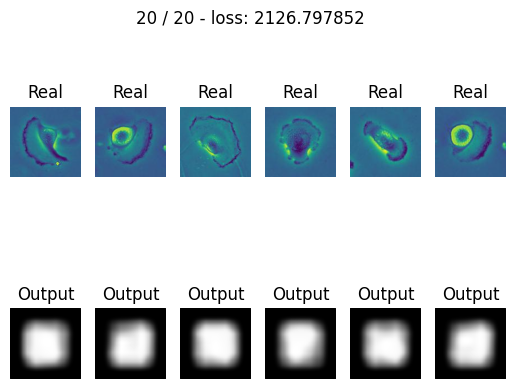

In [8]:
model = EncDec().to(device)
train(model, optim.Adam(model.parameters(), 0.0001), focal_loss, 20, train_loader, test_loader)

----------------------------------------------------------------------------------------------

## Regularization

The more of our prior knowledge we can feed the neural network, the better. One way to introduce such background knowledge is by regularization. Regularization are extra terms added to the loss function.

**Centered:** if you know the segmentation is always centered, you can punish it if it is not.

$$\mathcal L_{centered}(y,\hat y) = 1-\sigma(\hat y_{w/2,h/2})$$

**Sparcity:** if there is a lot of sparcity (small patches of segmentation), you can add an L1 term:

$$\mathcal L_{sparcity} = \sigma(\hat y)$$

**Contiguity:** to avoid many zig-zags in the semantic frontier, [total variation](https://en.wikipedia.org/wiki/Total_variation_denoising) can be used:

$$\mathcal L_{contiguity} = \sum_{i,j}|\sigma(\hat y_{i+1,j})-\sigma(\hat y_{i,j})|+\sum_{i,j}|\sigma(\hat y_{i,j+1})-\sigma(\hat y_{i,j})|$$

* Ferreira, P. M., Marques, F., Cardoso, J. S., & Rebelo, A. (2018). "[Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Add the total variation term to the loss.</div>

In [44]:
def total_variation(y_real, y_pred, v1 = False):
    y_pred = F.sigmoid(y_pred)
        # l1 = torch.sum(torch.abs(Y[:, :, 1:, :] - Y[:, :,  :-1, :]), dim = (-2, -1))
        # l2 = torch.sum(torch.abs(Y[:, :, :, 1:] - Y[:, :, :, :-1]), dim = (-2, -1))
       
    # Compute the total variation of the predicted image
    diff_i = torch.abs(y_pred[:, :, 1:, :] - y_pred[:, :, :-1, :])
    diff_j = torch.abs(y_pred[:, :, :, 1:] - y_pred[:, :, :, :-1])
    tv = torch.mean(diff_i) + torch.mean(diff_j)
    return tv
    

def bce_total_variation(y_real, y_pred):
    # return bce_loss(y_real, y_pred) + 0.1*...
    bce = bce_loss(y_pred, y_real)
    tv = total_variation(y_real, y_pred)
    # print(bce.item(), tv.item())
    return bce + 0.1*tv

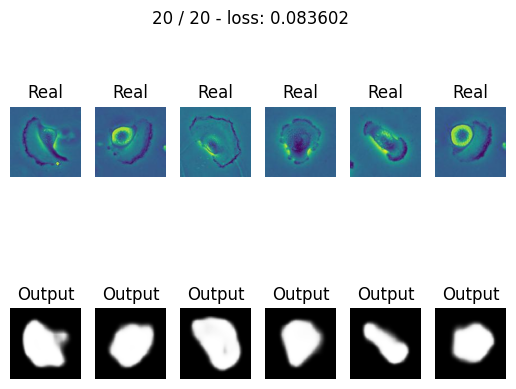

In [45]:
model = EncDec().to(device)
train(model, optim.Adam(model.parameters()), bce_total_variation, 20, train_loader, test_loader)

-----------------------------------------------------------------------------------------

# U-Net

A [**U-Net**](https://arxiv.org/abs/1505.04597) is a neural network architecture that receives an image and outputs an image. It was originally conceived for semantic segmentation (as we will use it), but it is so successfully that it has since been used in other contexts. Given a medical image, it outputs a grayscale image representing the probability of each pixel being the region of interest.

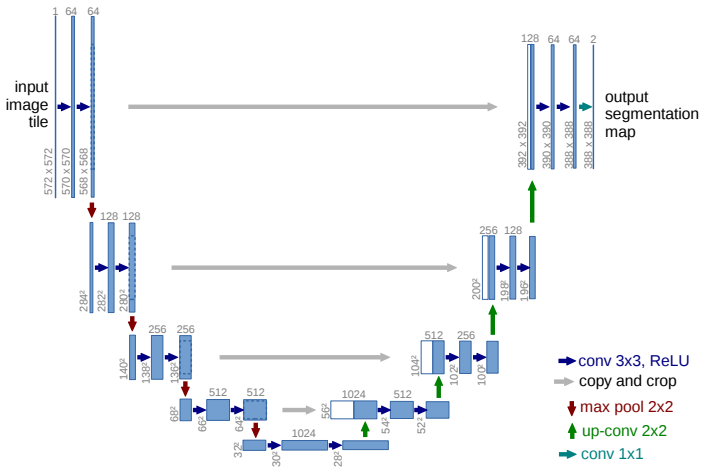

Like **SegNet,** this architecture is composed by two parts: Half of the network applies convolutions and pooling layers to successively reduce the input image (*encoder*). The other half successively increases the size of the image (*decoder*). In the end, we have an output image with the same size as the input image, but the number of channels might be different (e.g. the output might be grayscale and the input can be RGB).

Unlike **SegNet,** U-Net adds skip-connections:

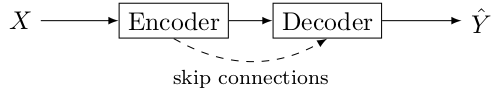

Notice that the activation map along the SegNet network are symmetric. That is, the size of the activation map in the 1st layer is equal to the size of the last layer, the size of the 2nd layer's activations is equal to the penultimate activations, etc. The authors took advantage of this fact to introduce skip-connections to further improve the performance of the networks. What these skip-connections do is to connect each layer not only to the previous layer, but also to its twin layer. This allows gradients to travel more freely (avoiding things like vanishing gradients) and also helps avoid checkboard artifacts which sometimes plagues this type of networks.

This can be done during `fpass` by concatenating (`torch.cat`) the encoding output to the respective decoding input. For example, `torch.cat([d0, e2], 1)`.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
    <b><i>Exercise:</i></b> Copy the <tt>SegNet</tt> model and rename it to <tt>UNet</tt>. Then introduce the skip connections using <tt>torch.concat</tt> in the <tt>forward()</tt> function. In the end, you will also need to adjust the input size of each convolution in the constructor.
</div>

> SegNet is named EncDec above

In [81]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(64*2, 1, 3, padding=1)

    def forward(self, x):
        # obs - we split the pooling and the conv layers to be able to concatenate them later in the skip connection
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e01 = self.pool0(e0)
        e1 = F.relu(self.enc_conv1(e01))
        e11 = self.pool1(e1)
        e2 = F.relu(self.enc_conv2(e11))
        e21 = self.pool2(e2)
        e3 = F.relu(self.enc_conv3(e21))
        e31 = self.pool3(e3)
        

        # bottleneck
        b = F.relu(self.bottleneck_conv(e31))

        # decoder
        # u0 = self.upsample0(b)
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b), e3], 1)))
        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), e2], 1)))
        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1), e1], 1)))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], 1))  # no activation
        return d3

In [84]:
model = UNet().to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
         MaxPool2d-2           [-1, 64, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          36,928
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          36,928
         MaxPool2d-8             [-1, 64, 8, 8]               0
            Conv2d-9             [-1, 64, 8, 8]          36,928
         Upsample-10           [-1, 64, 16, 16]               0
           Conv2d-11           [-1, 64, 16, 16]          73,792
         Upsample-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          73,792
         Upsample-14           [-1, 64,

This summary is no longer useful to see the model, since the model is no longer sequential. Therefore, we will use the package `torchviz` to draw a diagram of the model you implemented:

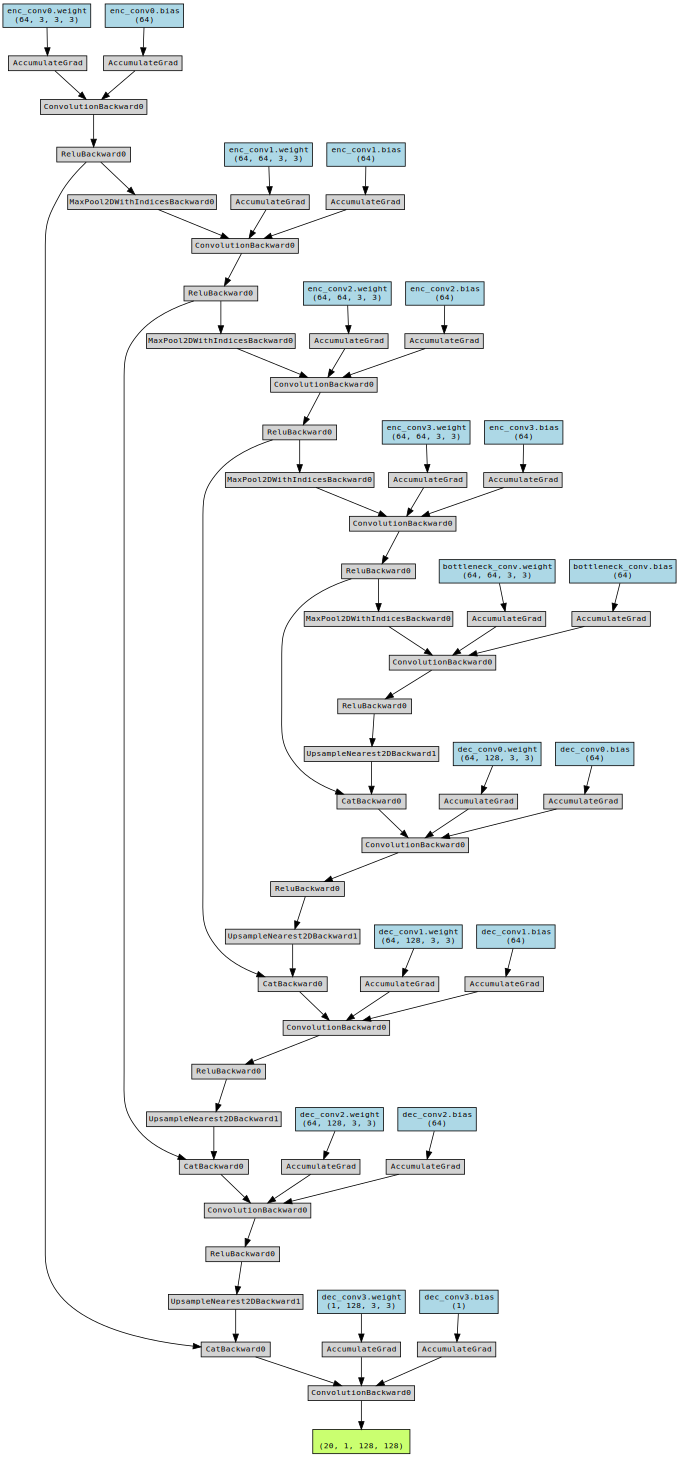

In [87]:
from torchviz import make_dot
make_dot(model(torch.randn(20, 3, 128, 128).cuda()), params=dict(model.named_parameters()))

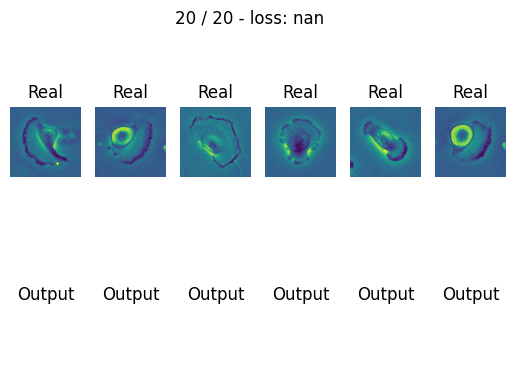

In [97]:
torch.cuda.empty_cache()
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

---------------------------------------------------------------------------------------------------

So far, we have been using **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

As been discussed last week, downsample can also be done with stride=2, and upsample with stride=1/2. This generally works better than using max-pooling and upsample.

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Replace max-pooling by convolutions with stride=2, and replace upsampling by transpose-convolutions also with stride=2.
</div>

In [9]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        pool_kernel_size = 2
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 128 -> 64
        # self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 64 -> 32
        # self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 32 -> 16
        # self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        # self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8
        self.pool3 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        # self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.upsample0 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        # self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        # self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample3 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        # self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(64*2, 1, 3, padding=1)

    def forward(self, x):
        # obs - we split the pooling and the conv layers to be able to concatenate them later in the skip connection
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e01 = self.pool0(e0)
        e1 = F.relu(self.enc_conv1(e01))
        e11 = self.pool1(e1)
        e2 = F.relu(self.enc_conv2(e11))
        e21 = self.pool2(e2)
        e3 = F.relu(self.enc_conv3(e21))
        e31 = self.pool3(e3)
        

        # bottleneck
        b = F.relu(self.bottleneck_conv(e31))

        # decoder
        # u0 = self.upsample0(b)
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b), e3], 1)))
        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), e2], 1)))
        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1), e1], 1)))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], 1))  # no activation
        return d3

In [10]:
model = UNet2().to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
            Conv2d-2           [-1, 64, 64, 64]          16,448
            Conv2d-3           [-1, 64, 64, 64]          36,928
            Conv2d-4           [-1, 64, 32, 32]          16,448
            Conv2d-5           [-1, 64, 32, 32]          36,928
            Conv2d-6           [-1, 64, 16, 16]          16,448
            Conv2d-7           [-1, 64, 16, 16]          36,928
            Conv2d-8             [-1, 64, 8, 8]          16,448
            Conv2d-9             [-1, 64, 8, 8]          36,928
  ConvTranspose2d-10           [-1, 64, 16, 16]          16,448
           Conv2d-11           [-1, 64, 16, 16]          73,792
  ConvTranspose2d-12           [-1, 64, 32, 32]          16,448
           Conv2d-13           [-1, 64, 32, 32]          73,792
  ConvTranspose2d-14           [-1, 64,

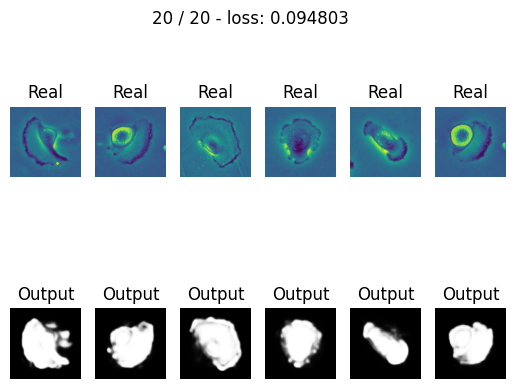

In [11]:
# torch.cuda.empty_cache()
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

# Dilated convolutions

We have been using encoder-decoder architectures, which are the most popular. But other architectures exist. For example, we could have used so-called **dilated convolutions** (also known as *à-trous convolutions*) as an alternative,

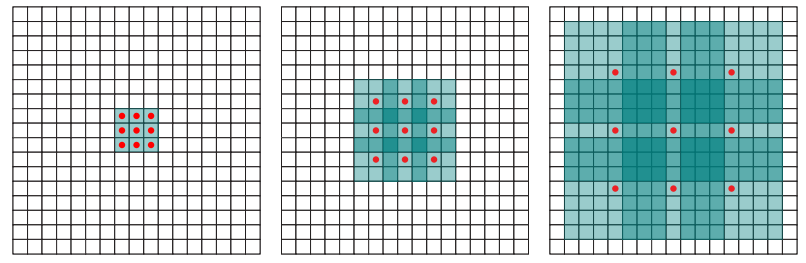

In the first layer, we use dilation=1, the second layer uses dilation=2, and so on, until a good part of the receptive field is reached.

* Yu, Fisher, and Vladlen Koltun. "[Multi-scale context aggregation by dilated convolutions.](https://arxiv.org/pdf/1511.07122.pdf)" arXiv preprint arXiv:1511.07122 (2015).

<div style="border-left: solid 6px #d6d6d6; padding: 10px; background-color: #eaeaea">
<b><i>Exercise:</i></b> Copy SegNet and implement a <tt>DilatedNet</tt> using dilated filters instead of down-sampling and up-sampling.
</div>

In [29]:
class DilatedNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1, dilation=1)
        # self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=2, dilation=2)
        # self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=3, dilation=3)
        # self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 1, 3, padding=4, dilation=4)
        # self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8


    def forward(self, x):
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e1 = F.relu(self.enc_conv1(e0))
        e2 = F.relu(self.enc_conv2(e1))
        e3 = self.enc_conv3(e2)

        # # bottleneck
        # b = F.relu(self.bottleneck_conv(e3))

        # # decoder
        # d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        # d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        # d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        # d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return e3

In [30]:
model = DilatedNet().to(device)
summary(model, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
            Conv2d-2         [-1, 64, 128, 128]          36,928
            Conv2d-3         [-1, 64, 128, 128]          36,928
            Conv2d-4          [-1, 1, 128, 128]             577
Total params: 76,225
Trainable params: 76,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 24.12
Params size (MB): 0.29
Estimated Total Size (MB): 24.60
----------------------------------------------------------------


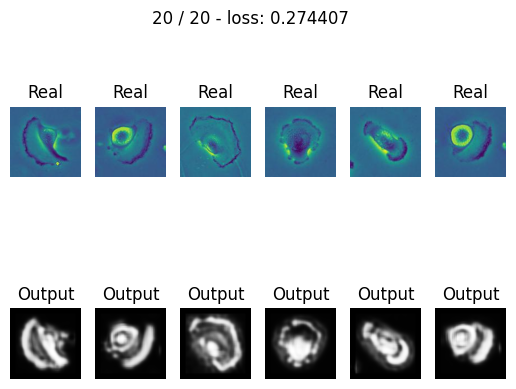

In [31]:
train(model, optim.Adam(model.parameters()), bce_loss, 20, train_loader, test_loader)

---------------------------------------------------------------------------------------------------------

# Multi-class Segmentation

1. Use the [CMP-Facade dataset](http://cmp.felk.cvut.cz/~tylecr1/facade/) that you find at 

    /dtu/datasets1/02514/CMP_facade_DB_base

2. Load the dataset. There are 12 classes, therefore, each segmentation will have the shape $12\times H\times W$. 
3. Copy over one of the previous models and adapt for multi-class segmentation. The most important change is the to *loss function.* Feel free to use [this pytorch loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) which implements softmax-crossentropy.

In [19]:
np.unique(plt.imread("/dtu/datasets1/02514/CMP_facade_DB_base/base/cmp_b0002.png"), return_counts=True)

(array([0.        , 0.33333334, 0.6666667 , 1.        ], dtype=float32),
 array([485381, 162998, 164158, 817671]))

In [15]:
masks.shape, images.shape

(torch.Size([4, 1, 256, 256]), torch.Size([4, 3, 256, 256]))

Load:

In [3]:
root_dir = "/dtu/datasets1/02514/CMP_facade_DB_base"

import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import glob
import matplotlib.pyplot as plt

class CMPFacadeDataset(Dataset):
    num_labels = 13
    
    unique_colors = [
        [  0,   0,   0],
        [  0,   0, 170],
        [  0,   0, 255],
        [  0,  85, 255],
        [  0, 170, 255],
        [  0, 255, 255],
        [ 85, 255, 170],
        [170,   0,   0],
        [170, 255,  85],
        [255,   0,   0],
        [255,  85,   0],
        [255, 170,   0],
        [255, 255,   0]
    ]
    
    id2label = {
        0: "unknown",
        1: "background",
        2: "facade", 
        3: "window", 
        4: "door", 
        5: "cornice", 
        6: "sill", 
        7: "balcony", 
        8: "blind",  
        9: "pillar",
        10: "deco", 
        11: "molding",
        12: "shop"
    }
    
    def __init__(self, root_dir):
        self.root_dir = root_dir
        # self.transform = transform
        # self.filenames = sorted(os.listdir(root_dir))
        self.img_files = sorted(glob.glob(os.path.join(root_dir, "base", '*.jpg')))
        self.mask_files = sorted(glob.glob(os.path.join(root_dir, "base", '*.png')))
        
        
        # create labels dict
        label_file = os.path.join(root_dir, 'label_names.txt')
        self.labels = {}
        self.label_counts = {}
        with open(label_file, 'r') as f:
            for line in f.readlines():
                label = line.strip("\n").split(" ")
                self.labels[int(label[0])] = label[1]
                self.label_counts[int(label[0])] = int(label[2])

        # define transforms        
        self.image_transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
        
        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor()
        ])
        

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image and mask
        # img_path = os.path.join(self.root_dir, self.filenames[idx])
        # mask_path = img_path.replace('.jpg', '.png')
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]
        image = Image.open(img_path).convert("RGB").copy()#.convert('RGB')
        mask = Image.open(mask_path).convert('P').copy()#.convert('L')

        # Apply transforms
        # if self.transform is not None:
        image = self.image_transform(image)
        mask = self.mask_transform(mask)
            # mask = self.transform(mask)

        return image, mask
    
    def parse_segmentation_image(self, segmentation_image):
        """
        Map RGB pixel values in the segmentation image to class ids.
        Args:
            segmentation_image: a WxHx3 numpy array representing the segmentation image
            unique_colors: a list of unique RGB values in the image
        Returns:
            A WxH numpy array where each element is the class id for the corresponding
            pixel in the segmentation image.
        """
        # Create a mapping from RGB values to class ids
        color_to_class = {tuple(color): i for i, color in enumerate(self.unique_colors)}

        # Initialize the output array with the correct number of classes
        output = np.zeros((segmentation_image.shape[0], segmentation_image.shape[1]), dtype=np.uint8)

        # Map the RGB values to class ids
        for i in range(segmentation_image.shape[0]):
            for j in range(segmentation_image.shape[1]):
                output[i, j] = color_to_class[tuple(segmentation_image[i, j])]

        return output



# # Create dataset and data loader
# dataset = CMPFacadeDataset(root_dir)
# dataloader = DataLoader(torch.subdataset, batch_size=4, shuffle=True)

# Create dataset and split into train and test subsets
dataset = CMPFacadeDataset(root_dir)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create train and test data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

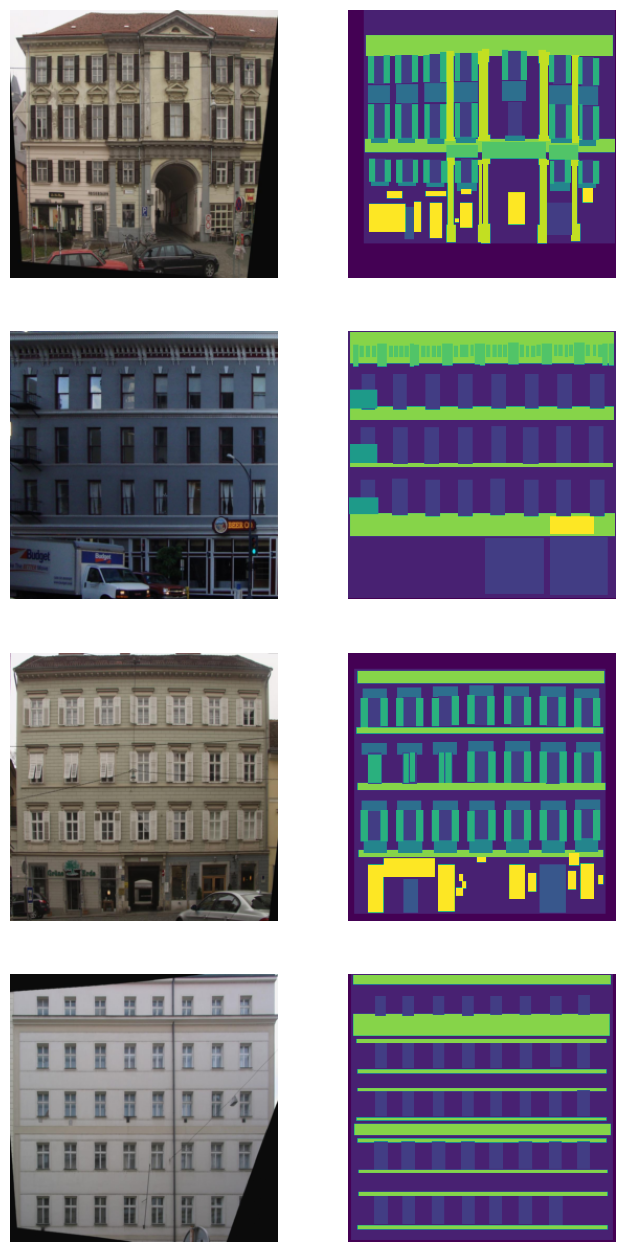

In [4]:
from matplotlib import cm
import numpy as np
import matplotlib
# Get a batch of images and masks
images, masks = next(iter(train_loader))

# create cmap
# cmap = cm.get_cmap('viridis', 12)
cmap = matplotlib.colormaps.get_cmap('viridis')

# Plot the images and masks
fig, axs = plt.subplots(4, 2, figsize=(8, 16))
for i in range(4):
    axs[i, 0].imshow(images[i].permute(1, 2, 0))
    axs[i, 0].axis('off')
    cax = axs[i, 1].imshow(masks[i].squeeze(), cmap = cmap, vmin=masks.min(), vmax=masks.max())
    # cax = axs[i, 1].imshow(masks[i].squeeze(), cmap = cmap, vmin=0, vmax=1)
    axs[i, 1].axis('off')
    
    # cbar = fig.colorbar(cax, ticks=list(np.linspace(masks.min(), masks.max(), 12)))
    # cbar.ax.set_yticklabels(dataset.labels.values())  # vertically oriented colorbar
    
    # add label
# plt.colorbar()
    
plt.show()

Model:

In [5]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        pool_kernel_size = 2
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 128 -> 64
        # self.pool0 = nn.MaxPool2d(2, 2)  # 128 -> 64
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 64 -> 32
        # self.pool1 = nn.MaxPool2d(2, 2)  # 64 -> 32
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 32 -> 16
        # self.pool2 = nn.MaxPool2d(2, 2)  # 32 -> 16
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        # self.pool3 = nn.MaxPool2d(2, 2)  # 16 -> 8
        self.pool3 = nn.Conv2d(64, 64, pool_kernel_size, stride=2)  # 16 -> 8

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        # self.upsample0 = nn.Upsample(16)  # 8 -> 16
        self.upsample0 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        # self.upsample1 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample2 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        # self.upsample2 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample3 = nn.ConvTranspose2d(64, 64, 2, stride = 2)
        # self.upsample3 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv3 = nn.Conv2d(64*2, 12, 3, padding=1)

    def forward(self, x):
        # obs - we split the pooling and the conv layers to be able to concatenate them later in the skip connection
        # encoder
        e0 = F.relu(self.enc_conv0(x))
        e01 = self.pool0(e0)
        e1 = F.relu(self.enc_conv1(e01))
        e11 = self.pool1(e1)
        e2 = F.relu(self.enc_conv2(e11))
        e21 = self.pool2(e2)
        e3 = F.relu(self.enc_conv3(e21))
        e31 = self.pool3(e3)
        

        # bottleneck
        b = F.relu(self.bottleneck_conv(e31))

        # decoder
        # u0 = self.upsample0(b)
        d0 = F.relu(self.dec_conv0(torch.cat([self.upsample0(b), e3], 1)))
        d1 = F.relu(self.dec_conv1(torch.cat([self.upsample1(d0), e2], 1)))
        d2 = F.relu(self.dec_conv2(torch.cat([self.upsample2(d1), e1], 1)))
        d3 = self.dec_conv3(torch.cat([self.upsample3(d2), e0], 1))  # no activation
        return d3
    
model = UNet2().to(device)
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
            Conv2d-2         [-1, 64, 128, 128]          16,448
            Conv2d-3         [-1, 64, 128, 128]          36,928
            Conv2d-4           [-1, 64, 64, 64]          16,448
            Conv2d-5           [-1, 64, 64, 64]          36,928
            Conv2d-6           [-1, 64, 32, 32]          16,448
            Conv2d-7           [-1, 64, 32, 32]          36,928
            Conv2d-8           [-1, 64, 16, 16]          16,448
            Conv2d-9           [-1, 64, 16, 16]          36,928
  ConvTranspose2d-10           [-1, 64, 32, 32]          16,448
           Conv2d-11           [-1, 64, 32, 32]          73,792
  ConvTranspose2d-12           [-1, 64, 64, 64]          16,448
           Conv2d-13           [-1, 64, 64, 64]          73,792
  ConvTranspose2d-14         [-1, 64, 1

Training:

In [8]:
train(model, optim.Adam(model.parameters()), nn.CrossEntropyLoss(), 20, train_loader, test_loader)

* Epoch 1/20


RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: : [4, 12, 256, 256]

-----------------------------------------------------------------------------------------

# Further Thoughts

1. Especially when there is little data, **transfer-learning** can also be used for segmentation. A popular approach is to replace the encoder part of the U-Net by the convolutional part of VGG-16.
2. **Data augmentation** can also be used to improve segmentation quality. Special care must be taken because (i) some augmentation is symmetric and must be applied in pairs like rotation, and (ii) some augmentation is asymmetric like brightness.
3. The same framework from **Generative Adverserial Networks** (week 3) can be used to improve semantic segmentation. That is, you can see your segmentation network as a generator, and a discriminator can be used as a critic to further improve the ensuing segmentations. (e.g., [SegAN](https://arxiv.org/abs/1706.01805))
4. To learn a segmentation model, we first need to create the segmentations. Do humans learn like this? Can we bypass that and learn how to segment [without **supervision**](https://arxiv.org/abs/1705.08168)?
5. We have covered here *semantic* segmentation. What could we have done differently for *instance* segmentation?

In [86]:
masks.shape

torch.Size([4, 1, 256, 256])